In [1]:
#Importing HOOMD and HOOMD.md so we can access the methods that they both
#have and so we can run our simulation. 

import hoomd
import hoomd.md

In [2]:
#Here we initialize where the simulation is going to be run. Since we
#didn't put anything in as a parameter, HOOMD will select where the simulation
#is going to run - a GPU if it exists or a CPU.

hoomd.context.initialize("");

HOOMD-blue 2.3.0 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [3]:
#"hoomd.init.create_lattice()" takes a unit cell and replicates it the
#amount of times specified in each direction. It takes two parameters - the
#first is the unit cell and the second is the number of times to be multiplied 
#in each direction (n=5 so 5 times in each direction).

#"hoomd.lattice.sc()" creates a unit cell that is a x a x a where 'a' is the lattice
#constant. It is possible to specify the l,w, and h of it with 3 variables if
#you want but we make a square here with only one value. It is also possible to 
#specify type name as a parameter but if you don't, the default is 'A'.

#We specify what the unit cell is in the code by using "unitcell=" but since it
#is the first parameter, you don't need to use it since the computer will understand
#what it is referring to.

hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5);

notice(2): Group "all" created containing 125 particles


In [4]:
#We are creating a neighborlist here using the cell method. ".cell()" has quite
#a few parameters but since we don't specify any of them, it uses the default
#values it has been programmed with. We call this neighborlist 'n1'.

#Cell method uses O(n). The cell list method is the fastest when r_cut is similar
#between all pair forces because then you don't need to worry about checking an atom
#and then having to skip it. Almost all will be in the correct range. This 
#method degrades with the more particles you have per cell.

n1 = hoomd.md.nlist.cell();

In [5]:
#"hoomd.md.pair.lj()" says that the LJ potential should be applied between
#every non-excluded particle pair (this is determined by neighbor list)

#takes in two parameters - r_cut which is the cutoff radius for the neighbor list
#and a neighborlist (we specified it earlier). We need to use nlist to define it
#because there is also a name parameter and we don't want the computer to get
#confused.

lj = hoomd.md.pair.lj(r_cut=2.5, nlist=n1);

In [6]:
#"pair_coeff.set()" sets potential energy coefficients - THIS MUST BE DONE

#you do it for each pair type in the simulation and should be specific for each
#unique type

#epsilon is in energy units - well depth of LJ Potential graph (can affect
#stickiness) - in a unary mixture, it doesn't make sense to not use one

#sigma is in distance units - diameter of the particle (doesn't really change
#what happens in HOOMD but would in VMD)

#Since we only have 'A' particles, the only unique pair of interactions 
#happens between two of them (I think you could have multiple lines for 
#different pairs?)

lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0);

In [7]:
#To "integrate" (move?) the system forward in time, you have to set an integration
#technique and the last one before hoomd.run() is the one that is used. 

#"mode_standard()" performs a standard time step integration - in each step,
#all forces are evaluated and applied before moving - you must do this to set dt

#HOWEVER, this actually does nothing because you have to specify an actual 
#integration system (do that on next line) - we are going to use Langevin

#dt = time units - each time step will advance the simulation by dt

hoomd.md.integrate.mode_standard(dt=.01);

In [8]:
#"hoomd.group.all()" takes all the particles in the simulation and forms a group of them - 
#this is done for the langevin equation

#"hoomd.md.integrate.langevin()" has multiple parameters - group of particles to apply the 
#equation to, temp in energy units, and a seed so that we get the same results each time
#(there are others but we don't need them)

all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=0, seed=42);

notice(2): integrate.langevin/bd is using specified gamma values


In [9]:
#puts the potential energy and temperature data into a file that organizes the data
#gives us parameters of - 
    #a file name for the data to go into
    #the quanitites that we want it to keep track of and record
    #the period for which data is tracked (time steps/period gives you the number of data points collected)
    #overwrite tells us the file will be overwritten with new data when the simulation runs again

hoomd.analyze.log(filename="log-output.log",
                 quantities=['potential_energy', 'temperature'],
                 period=100,
                 overwrite=True);

In [18]:
#states that "hoomd.dump.gsd()" writes simulation snapshots in the gsd format - basically it is a file with the 
#particle data in it so that VMD can run it and make a picture

#period tells us how often information is recorded (time step/period)
#group tells us what group of particles we want to go in the file
#overwrite tells us the file will be overwritten with new data when the simulation runs again

#"GSD is capable of storing all particle and bond data fields in hoomd in every frame of the trajectory" - this allows
#GSD to track lots of data and anything that is changing during the simulation

hoomd.dump.gsd("trajectory.gsd", period=2e4, group=all, overwrite=True);

In [23]:
#runs the simulation the stated number of time steps
#the number of frames on vmd is the number of time steps divided by the period from above

hoomd.run(1e4);

** starting run **
Time 01:18:57 | Step 220000 / 220000 | TPS 20679.9 | ETA 00:00:00
Average TPS: 20610.4
---------
-- Neighborlist stats:
0 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 53 / n_neigh_avg: 14.88
shortest rebuild period: 100
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 0 / n_max: 19 / n_avg: 4.62963
** run complete **


In [20]:
#these lines get our software set up to make graphs and puts all of our information in the variable called data
#"numpy.genfromtxt()" loads data from a file

import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

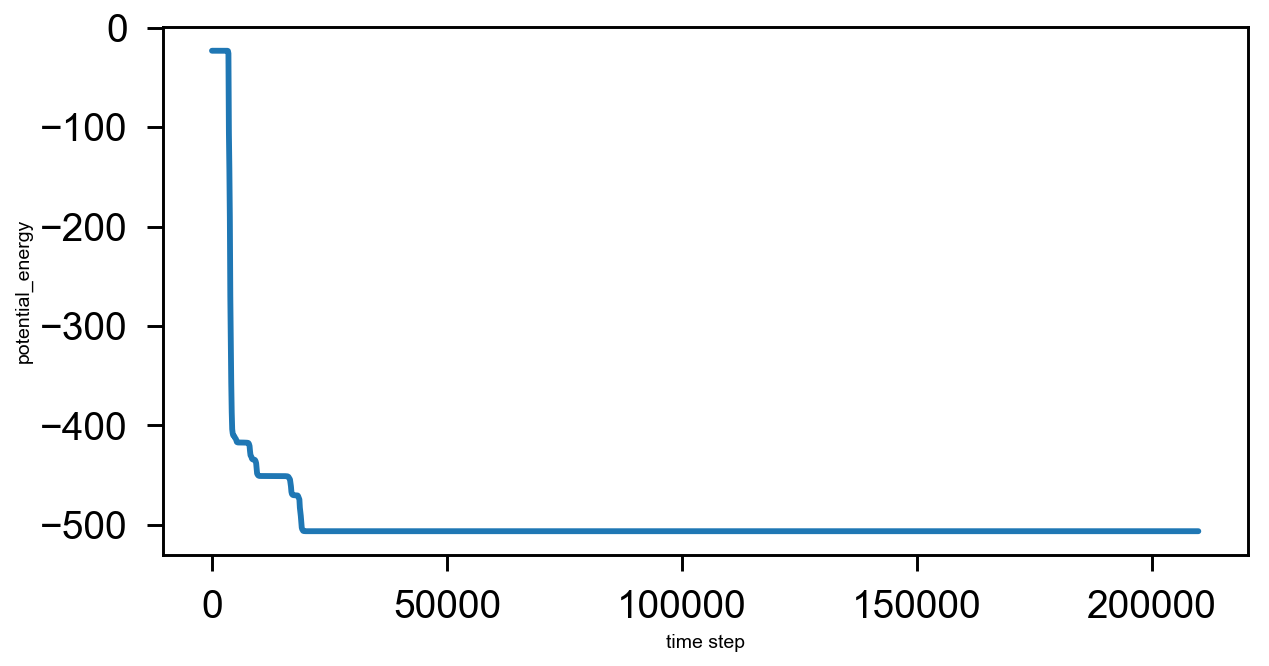

In [21]:
pyplot.figure(figsize=(10,5), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');

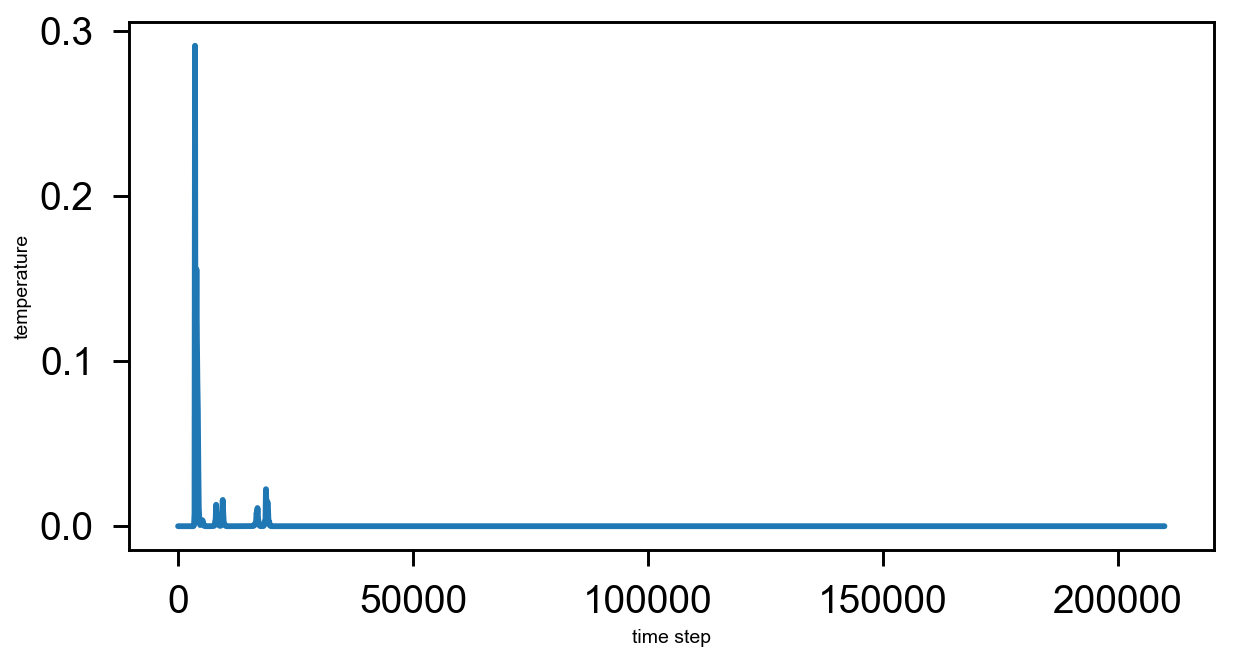

In [22]:
pyplot.figure(figsize=(10,5), dpi=140);
pyplot.plot(data[:,0], data[:,2]);
pyplot.xlabel('time step');
pyplot.ylabel('temperature');